In [1]:
import pandas as pd

#Dataset Paths
TRAIN_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_train_v2.csv'
VAL_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_validation_v2.csv'
TEST_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_test_v2.csv'

TRAIN_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\train_v2\train'
VAL_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\validation_v2\validation'
TEST_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\test_v2\test'

#Load & Clean Data
train_df = pd.read_csv(TRAIN_CSV).dropna(subset=["FILENAME", "IDENTITY"])

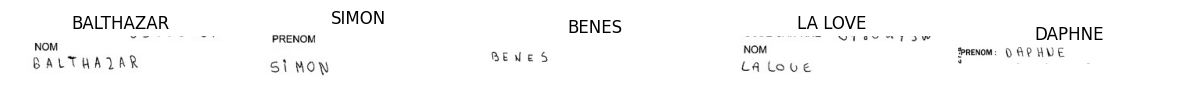

In [2]:
#Expected Output from train images

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

TRAIN_IMG_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\train_v2\train'

def load_image_pil(path):
    try:
        img = Image.open(path).convert('L')  # grayscale
        return np.array(img)
    except Exception as e:
        print(f"⚠️ Error loading image {path}: {e}")
        return None

plt.figure(figsize=(12, 4))
for i in range(5):
    img_path = os.path.join(TRAIN_IMG_DIR, train_df['FILENAME'].iloc[i])
    img = load_image_pil(img_path)
    
    plt.subplot(1, 5, i+1)
    
    if img is not None:
        plt.imshow(img, cmap='gray')
        plt.title(train_df['IDENTITY'].iloc[i])  
    else:
        plt.imshow(np.zeros((100, 100)), cmap='gray')
        plt.title('Image not found')
    
    plt.axis('off')

plt.tight_layout()
plt.show()


In [3]:
#Paths for CSVs and images

TRAIN_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_train_v2.csv'
VAL_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_validation_v2.csv'
TEST_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_test_v2.csv'

TRAIN_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\train_v2\train'
VAL_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\validation_v2\validation'
TEST_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\test_v2\test'


In [4]:
%pip install editdistance


Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import editdistance

#Constants
IMG_W, IMG_H = 128, 32
BATCH_SIZE = 16
MAX_LABEL_LEN = 16
EPOCHS = 30

#Dataset Paths
TRAIN_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_train_v2.csv'
VAL_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_validation_v2.csv'
TEST_CSV = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\written_name_test_v2.csv'

TRAIN_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\train_v2\train'
VAL_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\validation_v2\validation'
TEST_DIR = r'C:\Users\berkay\OneDrive - student.cankaya.edu.tr\Masaüstü\ceng481\final-project\dataset\test_v2\test'

#Load & Clean Data
train_df = pd.read_csv(TRAIN_CSV).dropna(subset=["FILENAME", "IDENTITY"])
val_df = pd.read_csv(VAL_CSV).dropna(subset=["FILENAME", "IDENTITY"])
train_df["IDENTITY"] = train_df["IDENTITY"].astype(str).str.strip()
val_df["IDENTITY"] = val_df["IDENTITY"].astype(str).str.strip()
train_df["FILENAME"] = train_df["FILENAME"].str.strip()
val_df["FILENAME"] = val_df["FILENAME"].str.strip()

#Char Map 
char_list = sorted(set("".join(train_df["IDENTITY"])))
char_to_idx = {c: i + 1 for i, c in enumerate(char_list)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
NUM_CLASSES = len(char_to_idx) + 1

def encode_label(label): return [char_to_idx[c] for c in label if c in char_to_idx]
def decode_prediction(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    return ["".join([idx_to_char.get(x, '') for x in row if x > 0]) for row in results.numpy()]

#Data Generator 
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size, augment=False, max_steps=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.augment = augment
        self.max_steps = max_steps
        self.aug = ImageDataGenerator(
            rotation_range=8, width_shift_range=0.08,
            height_shift_range=0.08, shear_range=0.2, zoom_range=0.1
        ) if augment else None

    def __len__(self):
        return self.max_steps if self.max_steps else len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        imgs, labels, input_lens, label_lens = [], [], [], []

        for _, row in batch.iterrows():
            try:
                img = Image.open(os.path.join(self.img_dir, row.FILENAME)).convert('L').resize((IMG_W, IMG_H))
                img = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, -1)
                if self.augment: img = self.aug.random_transform(img)
                label = encode_label(row.IDENTITY)[:MAX_LABEL_LEN]
                if max(label, default=0) >= NUM_CLASSES: continue
                imgs.append(img)
                labels.append(label + [0] * (MAX_LABEL_LEN - len(label)))
                input_lens.append(IMG_W // 4)
                label_lens.append(len(label))
            except: continue

        return ({
            "image": np.array(imgs),
            "labels": np.array(labels),
            "input_len": np.expand_dims(input_lens, 1),
            "label_len": np.expand_dims(label_lens, 1)
        }, np.zeros((len(imgs), 1)))


# Model Definition
input_img = layers.Input(shape=(IMG_H, IMG_W, 1), name='image')


#Basic CNN 
x = layers.Conv2D(64, 3, padding='same', activation='relu')(input_img)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Permute((2, 1, 3))(x)
x = layers.Reshape((IMG_W // 4, -1))(x)
x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
x = layers.LayerNormalization()(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dropout(0.3)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
y_pred = layers.Dense(NUM_CLASSES, activation='softmax')(x)

labels = layers.Input(shape=(MAX_LABEL_LEN,), name='labels')
input_len = layers.Input(shape=(1,), name='input_len')
label_len = layers.Input(shape=(1,), name='label_len')
loss_out = layers.Lambda(lambda x: K.ctc_batch_cost(*x), name='ctc')([labels, y_pred, input_len, label_len])

model = Model(inputs=[input_img, labels, input_len, label_len], outputs=loss_out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=lambda y_true, y_pred: y_pred)
prediction_model = Model(inputs=input_img, outputs=y_pred)

#Subset and Generators
train_subset = train_df.sample(n=8192, random_state=42)
val_subset = val_df.sample(n=1024, random_state=42)
train_gen = DataGen(train_subset, TRAIN_DIR, BATCH_SIZE, augment=True)
val_gen = DataGen(val_subset, VAL_DIR, BATCH_SIZE)

#Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks, verbose=1)

#Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CTC Loss')
plt.legend(); plt.grid(); plt.show()

#Evaluation
sample_batch = next(iter(val_gen))
imgs = sample_batch[0]['image']
true_labels = sample_batch[0]['labels']
preds = prediction_model.predict(imgs)
decoded_preds = decode_prediction(preds)
true_texts = ["".join([idx_to_char.get(c, '') for c in row if c > 0]) for row in true_labels]

for i in range(5):
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"GT: {true_texts[i]}\nPred: {decoded_preds[i]}")
    plt.axis('off'); plt.show()

def levenshtein_acc(preds, truths):
    scores = []
    for p, t in zip(preds, truths):
        dist = editdistance.eval(p, t)
        max_len = max(len(p), len(t))
        scores.append(1 - dist / max_len if max_len else 1.0)
    return np.mean(scores)

exact_matches = [p == t for p, t in zip(decoded_preds, true_texts)]
print(f"[Levenshtein Similarity Accuracy]: {levenshtein_acc(decoded_preds, true_texts):.4f}")
print(f"[Exact Match Accuracy]: {np.mean(exact_matches):.4f}")




Epoch 1/30


c:\Users\berkay\miniconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 43/512 ━━━━━━━━━━━━━━━━━━━━ 1:48 231ms/step - loss: 39.3268

KeyboardInterrupt: 

In [ ]:
input_img = layers.Input(shape=(IMG_H, IMG_W,1), name="image")
x = layers.Conv2D(64,3,activation="relu",padding="same")(input_img)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128,3,activation="relu",padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)


#RNN
shape = x.shape
x = layers.Reshape((shape[1], shape[2]*shape[3]))(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
output = layers.Dense(len(char_to_idx)+1, activation="softmax")(x)

labels = layers.Input(name="labels", shape=(MAX_LABEL_LEN,), dtype="int32")
input_len = layers.Input(name="input_len", shape=(1,), dtype="int32")
label_len = layers.Input(name="label_len", shape=(1,), dtype="int32")

ctc_loss = layers.Lambda(lambda args: K.ctc_batch_cost(*args),
                         name="ctc")([labels, output, input_len, label_len])

model = Model(inputs=[input_img, labels, input_len, label_len], outputs=ctc_loss)
model.compile(optimizer="adam")
model.summary()

Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 32, 128,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_266 (Conv2D) │ (None, 32, 128,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_151   │ (None, 16, 64,    │          0 │ conv2d_266[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_267 (Conv2D) │ (None, 16, 64,    │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_152   │ (None, 8, 32,     │          0 │ conv2d_267[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_71          │ (None, 8, 4096)   │          0 │ max_pooling2d_15… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 8, 64)     │    262,208 │ reshape_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_142   │ (None, 8, 256)    │    197,632 │ dense_122[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_143   │ (None, 8, 256)    │    394,240 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, 16)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_123 (Dense)   │ (None, 8, 51)     │     13,107 │ bidirectional_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_len           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_len           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc (Lambda)        │ (None, 1)         │          0 │ labels[0][0],     │
│                     │                   │            │ dense_123[0][0],  │
│                     │                   │            │ input_len[0][0],  │
│                     │                   │            │ label_len[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 941,683 (3.59 MB)

 Trainable params: 941,683 (3.59 MB)

 Non-trainable params: 0 (0.00 B)

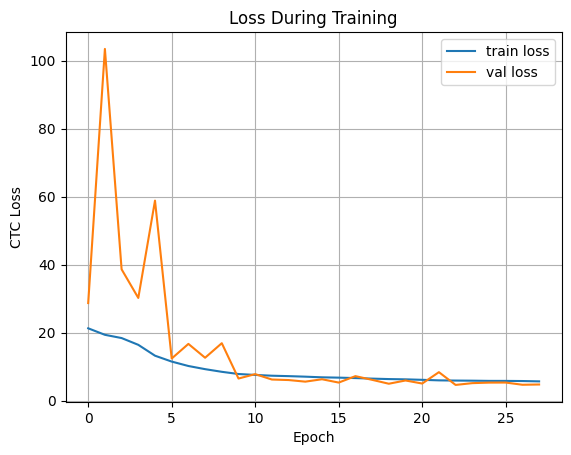

In [ ]:
#Plotting Loss During Training

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.legend()
plt.grid()
plt.show()



[Exact Match Accuracy]:     0.0000
[Levenshtein Similarity]:   0.0382

=== Character-level Scores ===
Precision: 0.0357
Recall:    0.0357
F1 Score:  0.0357


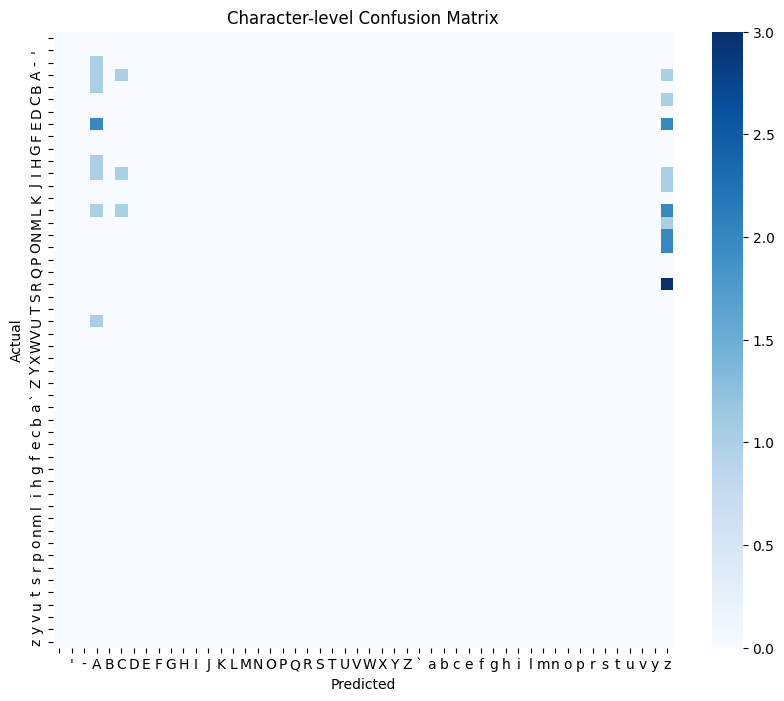

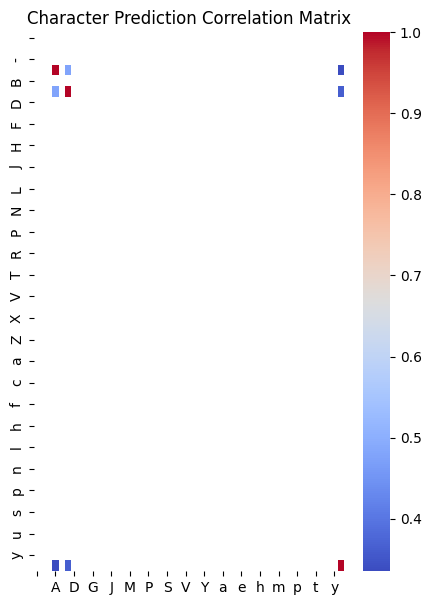

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import editdistance

true_labels = [row.IDENTITY for _, row in val_df.iloc[:len(decoded)].iterrows()]
pred_labels = decoded

# === Exact Match Accuracy ===
exact_matches = [1 if pred == true else 0 for pred, true in zip(pred_labels, true_labels)]
exact_acc = np.mean(exact_matches)

# === Levenshtein Accuracy ===
lev_sims = [
    1 - editdistance.eval(pred, true) / max(len(pred), len(true), 1)
    for pred, true in zip(pred_labels, true_labels)
]
lev_acc = np.mean(lev_sims)

print(f"\n[Exact Match Accuracy]:     {exact_acc:.4f}")
print(f"[Levenshtein Similarity]:   {lev_acc:.4f}")

# === Character-level metrics ===
y_true_chars = list("".join(true_labels))
y_pred_chars = list("".join(pred_labels))


min_len = min(len(y_true_chars), len(y_pred_chars))
y_true_chars = y_true_chars[:min_len]
y_pred_chars = y_pred_chars[:min_len]

# Precision, Recall, F1
precision = precision_score(y_true_chars, y_pred_chars, average='micro', zero_division=0)
recall = recall_score(y_true_chars, y_pred_chars, average='micro', zero_division=0)
f1 = f1_score(y_true_chars, y_pred_chars, average='micro', zero_division=0)

print("\n=== Character-level Scores ===")
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1 Score:  {:.4f}".format(f1))

# === Confusion Matrix ===
cm = confusion_matrix(y_true_chars, y_pred_chars, labels=char_list)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=char_list, yticklabels=char_list, cmap="Blues", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Character-level Confusion Matrix")
plt.show()

# === Correlation Matrix (Pearson) ===
cm_df = pd.DataFrame(cm, index=char_list, columns=char_list)
correlation_matrix = cm_df.corr()

plt.figure(figsize=(5, 7))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Character Prediction Correlation Matrix")
plt.show()



[Levenshtein Similarity] Average Accuracy ≈ 0.0592
[Exact Match Accuracy] 0.0000


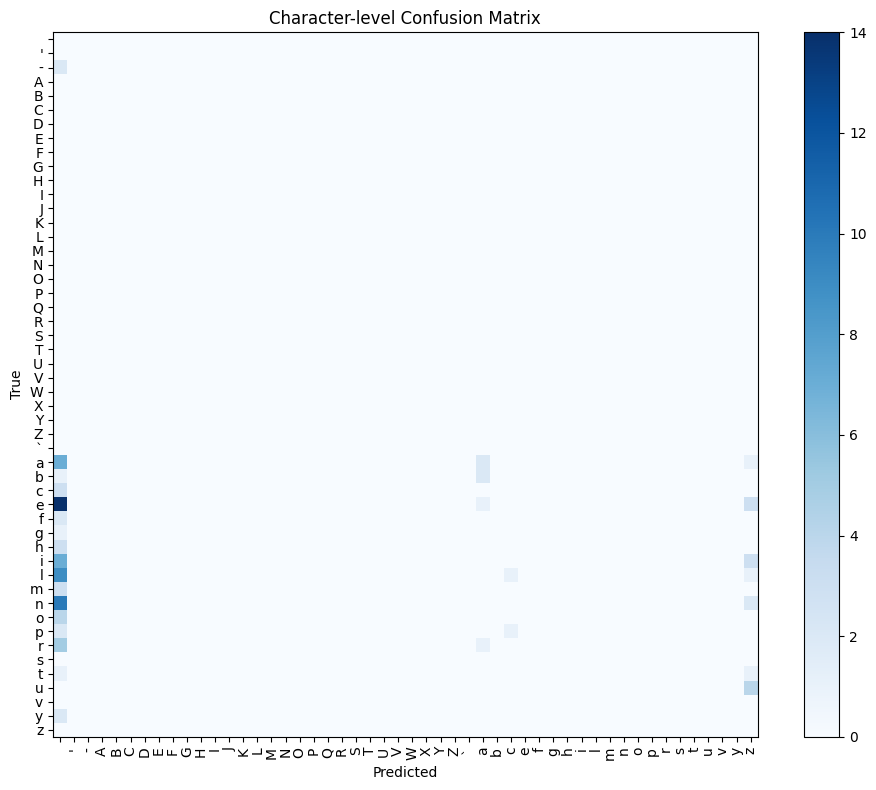

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from difflib import SequenceMatcher

# --- Utility function: Levenshtein ratio (approximate accuracy) ---
def levenshtein(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

# --- Collect predictions and true labels ---
true_texts = val_df.iloc[:len(decoded)]["IDENTITY"].tolist()
pred_texts = decoded

#Calculate average Levenshtein similarity 
lev_scores = [levenshtein(t.lower(), p.lower()) for t, p in zip(true_texts, pred_texts)]
avg_lev_score = np.mean(lev_scores)
print(f"\n[Levenshtein Similarity] Average Accuracy ≈ {avg_lev_score:.4f}")


#Classification Report 
true_labels = [t.lower()[:MAX_LABEL_LEN] for t in true_texts]
pred_labels = [p.lower()[:MAX_LABEL_LEN] for p in pred_texts]
exact_matches = [t == p for t, p in zip(true_labels, pred_labels)]
accuracy_exact_match = np.mean(exact_matches)
print(f"[Exact Match Accuracy] {accuracy_exact_match:.4f}")

# Character-level confusion matrix
y_true_chars = []
y_pred_chars = []

for t, p in zip(true_labels, pred_labels):
    for true_c, pred_c in zip(t, p.ljust(len(t))): 
        y_true_chars.append(true_c)
        y_pred_chars.append(pred_c)

conf_mat = confusion_matrix(y_true_chars, y_pred_chars, labels=char_list)
plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title("Character-level Confusion Matrix")
plt.xticks(ticks=np.arange(len(char_list)), labels=char_list, rotation=90)
plt.yticks(ticks=np.arange(len(char_list)), labels=char_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()
